In [1]:
import torch
print ("current pytorch version is: ", torch.__version__)

current pytorch version is:  1.7.1


In [78]:
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, models, datasets
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import os
import numpy as np
import time

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import cv2

In [3]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda:7')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    
device

tester = models.vgg16(pretrained=True)
last_layer = nn.Linear(4096, 10)
tester.classifier[6] = last_layer
tester.load_state_dict(torch.load(f'./models/model_1.pth'))

<All keys matched successfully>

In [4]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(tester.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

In [167]:
batch_size = 32
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

inputs, labels = next(iter(test_loader))
im = inputs[3]
label = labels[3]

Files already downloaded and verified
Files already downloaded and verified


In [168]:
#img: tensor
def imshow(img, name):
    img = img.cpu().detach()
    img = np.asarray(img, dtype='int64')
    img = np.transpose(img, (1, 2, 0))
#     cv2.imwrite(f'./images/{name}.png', img[:, :, [2, 1, 0]])
    plt.imshow(img)
    plt.show()
    
def imshow(img):
    plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")
    plt.show()

In [169]:
import random 
from deap import algorithms, base, creator, tools 
import numpy as np

creator.create("FitMin", base.Fitness, weights=(-1.0,))
creator.create("Ind", list, fitness=creator.FitMin)

/Applications/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Applications/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Ind' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [170]:
#  CIFAR = 32x32
SIZE = 32
#target = to misclassify label
TGT = 0
#population size 
POP_SIZE = 40
# one-pixel
NUM_PIXEL_ATTACK = 1

In [171]:
# populate with x,y and RGB values 
def generate_ind(size):
    # uniformly-distributed (x,y)
    x = random.randint(0,size-1)
    y = random.randint(0,size-1)
    # Normal RGB value, clamped between [0,255]
    R = random.gauss(128, 127)
    R = max(0, min(R, 255))
    G = random.gauss(128, 127)
    G = max(0, min(G, 255))
    B = random.gauss(128,127)
    B = max(0, min(B, 255))
    
    return (x,y,R,G,B)


toolbox = base.Toolbox()
toolbox.register("attribute", generate_ind, SIZE)
toolbox.register("ind", tools.initRepeat, creator.Ind, toolbox.attribute, n=NUM_PIXEL_ATTACK)
toolbox.register("pop", tools.initRepeat, list, toolbox.ind)


def three_random_nums():
    r1 = random.randint(0,POP_SIZE-1)
    r2 = random.randint(0,POP_SIZE-1)
    r3 = random.randint(0,POP_SIZE-1)
    while r1 == r2 or r1 == r3 or r2 == r3: 
        r1 = random.randint(0,POP_SIZE-1)
        r2 = random.randint(0,POP_SIZE-1)
        r3 = random.randint(0,POP_SIZE-1)
    return r1,r2,r3

#evolve solution features given three random candidate solutions
def evolve(p1, p2, p3):
    new_x = p1[0] + 0.5*(p2[0] - p3[0])
    new_x = int(32 * ((new_x + 16)/64))
    
    new_y = p1[1] + 0.5*(p2[1] - p3[1])
    new_y = int(32 * ((new_y + 16)/64))
    
    new_r = p1[2] + 0.5*(p2[2] - p3[2])
    new_r = 256 * ((new_r + 128)/512)
    
    new_g = p1[3] + 0.5*(p2[3] - p3[3])
    new_g = 256 * ((new_g + 128)/512)
    
    new_b = p1[4] + 0.5*(p2[4] - p3[4])
    new_b = 256 * ((new_b + 128)/512)
    
    return (new_x, new_y, new_r, new_g, new_b)

# return logit of targeted class prediction
# im: original image; tensor.Size(3,32,32)
# label: ground truth; scalar
def eval_adv(individual, im, label):
    
    #extract features
    ind = individual[0]
    x = ind[0]
    y = ind[1]
    r = ind[2]
    g = ind[3]
    b = ind[4]
    
    # apply change to original image
    adv_im = im.clone().detach() # to prevent contamination 
    adv_im[0][y][x] = r 
    adv_im[1][y][x] = g
    adv_im[2][y][x] = b
    
    # model prediction of ground truth class of this individual
    eval_im = torch.reshape(adv_im, (1,3,32,32)) #need [1,3,32,32] shape for model pred
    
    ##change name of model to model1
    tester.eval()
    with torch.no_grad():
        prob = tester(eval_im) #tensor([[10 probabilities]]), .Size([1,10])
    res = prob[0][label].item()
    
    return res,

In [172]:
toolbox.register("eval", eval_adv)

In [173]:
# create a ???single??? one-pixel adversarial image 
def px_attack(im, label, path):
    since = time.time()
    
    # im: torch(3,32,32) ; label: scalar -> need iterable for evolutions
    TGT = np.ones(POP_SIZE, dtype = np.int8) * label
    im_pop = []
    label_pop = []
    for i in range(POP_SIZE):
        im_pop.append(im)
        label_pop.append(label)
    
    pop = toolbox.pop(n=POP_SIZE)
    fitnesses = list(map(toolbox.eval, pop, im_pop, label_pop))

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    fits = [ind.fitness.values[0] for ind in pop]
    
    g = 0
    while g<2:
        ###### change g to 20 
        
        
        g += 1
        print("-- Generation %i --" % g)
        evolution_t = time.time()
        
        #generate children by differential evolution
        offspring = list(map(toolbox.clone, pop))
        for child in offspring:
            # pick three random candidate solutions
            r1,r2,r3 = three_random_nums()
            p1 = pop[r1][0]
            p2 = pop[r2][0]
            p3 = pop[r3][0]
            
            # evolve (x,y,r,g,b) attributes of child
            child[0] = evolve(p1,p2,p3)
            
        # get fitness values of children
        children_fitnesses = map(toolbox.eval, offspring, im_pop, label_pop)
        for child, fit in zip(offspring, children_fitnesses):
            child.fitness.values = fit
        child_fits = [child.fitness.values[0] for child in offspring]
        
        #replace parent if child has 'lower' fitness
        for parent, p_fit, c_fit in zip(pop, fits, child_fits):
            if c_fit < p_fit: 
                del parent.fitness.values
                parent.fitness.values = c_fit,    
        fits = [ind.fitness.values[0] for ind in pop]
        
        #statistics for this evolution
        length = len(pop)
        mean = sum(fits) / length
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        evolution_t = time.time() - evolution_t
        print('evol time', evolution_t)
        
#         #break out if (likely) successful attack, i.e. ground truth pred < 0
        if min(fits) < 0:
            print('exit:')
            break
        
    
    
    best = pop[np.argmin(np.asarray(fits))]
    #extract attributes
    att = best[0]
    x = att[0]
    y = att[1]
    r = att[2]
    g = att[3]
    b = att[4]
    # apply change to original image
    adv_im = im.clone().detach() # to prevent contamination 
    adv_im[0][y][x] = r 
    adv_im[1][y][x] = g
    adv_im[2][y][x] = b

    # save image to file
#     save_image(adv_im, path)
    
    test = torch.reshape(adv_im, (1,3,32,32))
    tester.eval()
    with torch.no_grad():
        output = tester(test) #tensor([[10 probabilities]]), .Size([1,10])
    misclassified_as = classes[output[0].argmax().item()]
    
  

    # test = torch.reshape(im, (1,3,32,32))
    # print(tester(test))
    
    print('adv_img created, total time:', time.time() - since)
    print('end of evolution:')
    
    #### 
#     print(best[0])
#     imshow(adv_im)
    
    
    
    return adv_im, best[0], misclassified_as

original true class: tensor(0) plane


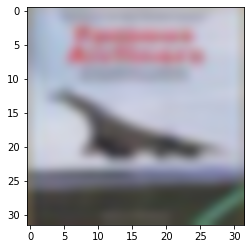

-- Generation 1 --
  Min 6.708041191101074
  Max 27.970914840698242
  Avg 17.12959372997284
evol time 2.3552658557891846
-- Generation 2 --
  Min 6.708041191101074
  Max 27.970914840698242
  Avg 16.343068337440492
evol time 2.3189210891723633
adv_img created, total time: 6.8495259284973145
end of evolution:
bird


In [174]:
print('original true class:', label, classes[label])
imshow(im)

## !!! 
#save model
name = 1
if not os.path.isdir('adv_im'):
        os.mkdir('adv_im') 
PATH = f'./adv_im/im_{name}.png' 

adv_image, adv_px, misclassified_as= px_attack(im, label.item(), PATH) #im: torch([3,32,32]) ; label: torch(scalar)
# print(im)

# imshow(adv_image)
print(misclassified_as)




(13, 14, 79.60682878097114, 0, 0)


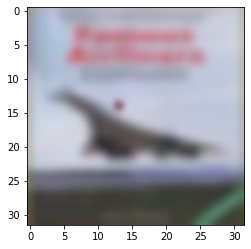

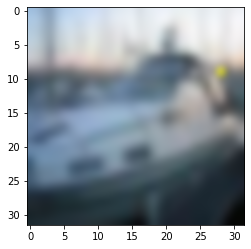

In [175]:
### how to display saved image from file 
print(adv_px)
imshow(adv_image)
# importing PIL 
from PIL import Image 
# Read image 
img = Image.open(PATH) 
# Output Images
img2 = transforms.ToTensor()(img)
# img2 = transforms.ToPILImage(mode='RGB')(img)
imshow(img2)



# # torch.from_numpy(img)
# # imshow(img)

# # trans = transforms.ToTensor()(img)
# # imshow(img)


# #load image 
# print('hi')
# loaded = cv2.imread(PATH,1)
# # cv2.imshow(loaded)
# print(type(loaded))
# torch.from_numpy(loaded)
# imshow(loaded)

# trans = transforms.ToTensor()(loaded)
# imshow(trans)